# МУРАВЬИ

In [1]:
from dataclasses import dataclass
import random
from math import inf, sqrt
from numpy import exp


class Base:
    @staticmethod
    def _calculate_dist(dm: list[list[float]], indx: list[int]) -> float:
        """Calculates the path length based on the index list of the distance matrix."""

        dist = 0
        for i in range(len(indx) - 1):
            dist += dm[indx[i]][indx[i + 1]]
        return dist


@dataclass
class Path:
    indx: list[int]
    leng: float


class ACO(Base):

    def __init__(self, ants: int, iter: int, a: float, b: float, p: float, q: float) -> None:

        self.ants = ants
        self.iter = iter
        self.a = a
        self.b = b
        self.p = p
        self.q = q
        self.best_lengths = []

    @staticmethod
    def __select_i(selection: list[int]) -> int:

        sum_num = sum(selection)
        if sum_num == 0:
            return len(selection) - 1
        tmp_num = random.random()
        prob = 0
        for i in range(len(selection)):
            prob += selection[i] / sum_num
            if prob >= tmp_num:
                return i

    def __create_indx(self, dm: list[list[float]], pm: list[list[float]]) -> list[int]:

        l = len(dm)
        unvisited_indx = list(range(l))
        random.shuffle(unvisited_indx)
        visited_indx = [unvisited_indx.pop()]
        for _ in range(l - 1):
            i = visited_indx[-1]
            selection = []
            for j in unvisited_indx:
                selection.append(
                    (pm[i][j] ** self.a) * ((1 / max(dm[i][j], 10 ** -5)) ** self.b)
                )
            selected_i = ACO.__select_i(selection)
            visited_indx.append(unvisited_indx.pop(selected_i))
        visited_indx.append(visited_indx[0])
        return visited_indx

    def update_pm(self, pm: list[list[float]], tmp_indx: list[list[int]], tmp_leng: list[float]) -> None:

        l = len(pm)
        for i in range(l):
            for j in range(i, l):
                pm[i][j] *= 1 - self.p
                pm[j][i] *= 1 - self.p
        for i in range(self.ants):
            delta = self.q / tmp_leng[i]
            indx = tmp_indx[i]
            for j in range(l):
                pm[indx[j]][indx[j + 1]] += delta
                pm[indx[j + 1]][indx[j]] += delta

    def run(self, dm: list[list[float]]):

        l = len(dm)
        pm = [[1 for _ in range(l)] for _ in range(l)]
        res_indx = []
        res_leng = inf
        for _ in range(self.iter):
            tmp_indx = []
            tmp_leng = []
            for _ in range(self.ants):
                indx = self.__create_indx(dm, pm)
                tmp_indx.append(indx)
                tmp_leng.append(ACO._calculate_dist(dm, indx))
            self.update_pm(pm, tmp_indx, tmp_leng)
            best_leng = min(tmp_leng)
            self.best_lengths.append(best_leng)
            if best_leng < res_leng:
                res_leng = best_leng
                res_indx = tmp_indx[tmp_leng.index(best_leng)]

        return Path(indx=res_indx, leng=res_leng), self.best_lengths


def run_algorithm(params, matrix):
    ants, iter, a, b, p, q = params
    distance_map = matrix.values.tolist()

    result,best_lengths = (ACO(ants=ants, iter=iter, a=a, b=b, p=p, q=q).run(dm=distance_map))

    return params, result,best_lengths

In [27]:
import pandas as pd
import geopandas as gpd

matrix = pd.read_csv('matrix.csv')
schools = gpd.read_file('schools.geojson')
matrix = matrix.astype(int)
matrix_25 =pd.read_csv('matrix_25.csv')
matrix_50 =pd.read_csv('matrix_50.csv')
matrix_125 = pd.read_csv('matrix_125.csv')
matrix_250 = pd.read_csv('matrix_250.csv')


In [4]:
import numpy as np
def random_cities(mtx, num=10):
    cities = list(mtx.index)
    np.random.shuffle(cities)
    new_mtx = mtx.iloc[cities[:num], cities[:num]]
    mapping = {i: new_mtx.index.values[i] for i in range(0, new_mtx.shape[0])}
    return new_mtx, mapping

In [3]:
import itertools
import sys
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

ants = [1, 2, 5, 25, 50, 100]
iter = [30, 35, 40, 60]
a = [0.5, 1.1, 2.5]
b = [1, 2, 4, 6]
p = [0.4, 0.5, 0.55, 0.6, 0.7]
q = [1, 3, 5, 7, 10]

param_grid = list(itertools.product(ants, iter, a, b, p, q))
random.seed(10)

matrix_1, mapping_1 = random_cities(matrix, 25) # Выборка срез матрицы

results = Parallel(n_jobs=-1)(delayed(run_algorithm)(params, matrix_1) for params in param_grid)  #n_jobs - кол-во ядер процессора

best_result = min(results, key=lambda x: x[1].leng)
best_params = best_result[0]
best_fitness = best_result[1].leng
best_path = best_result[1].indx

print(f"Лучшие параметры: {best_params} с результатом: {best_fitness}")



NameError: name 'random_cities' is not defined

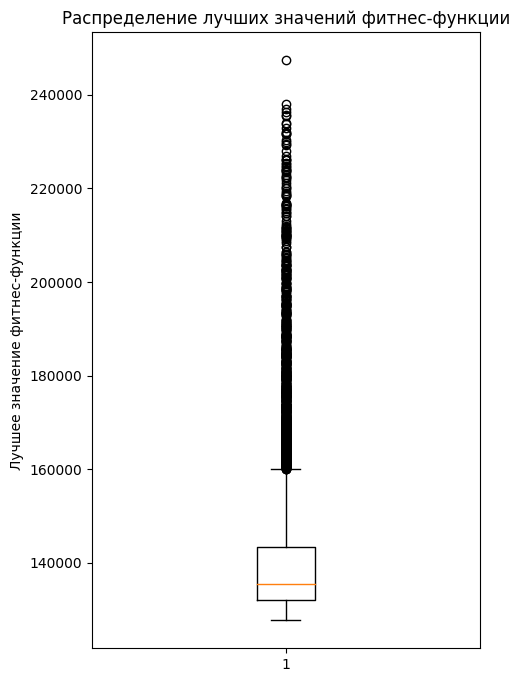

In [60]:
fig = plt.figure(figsize=(5,8))
best_fitness_values = [result[1].leng for result in results]
plt.boxplot(best_fitness_values)
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()

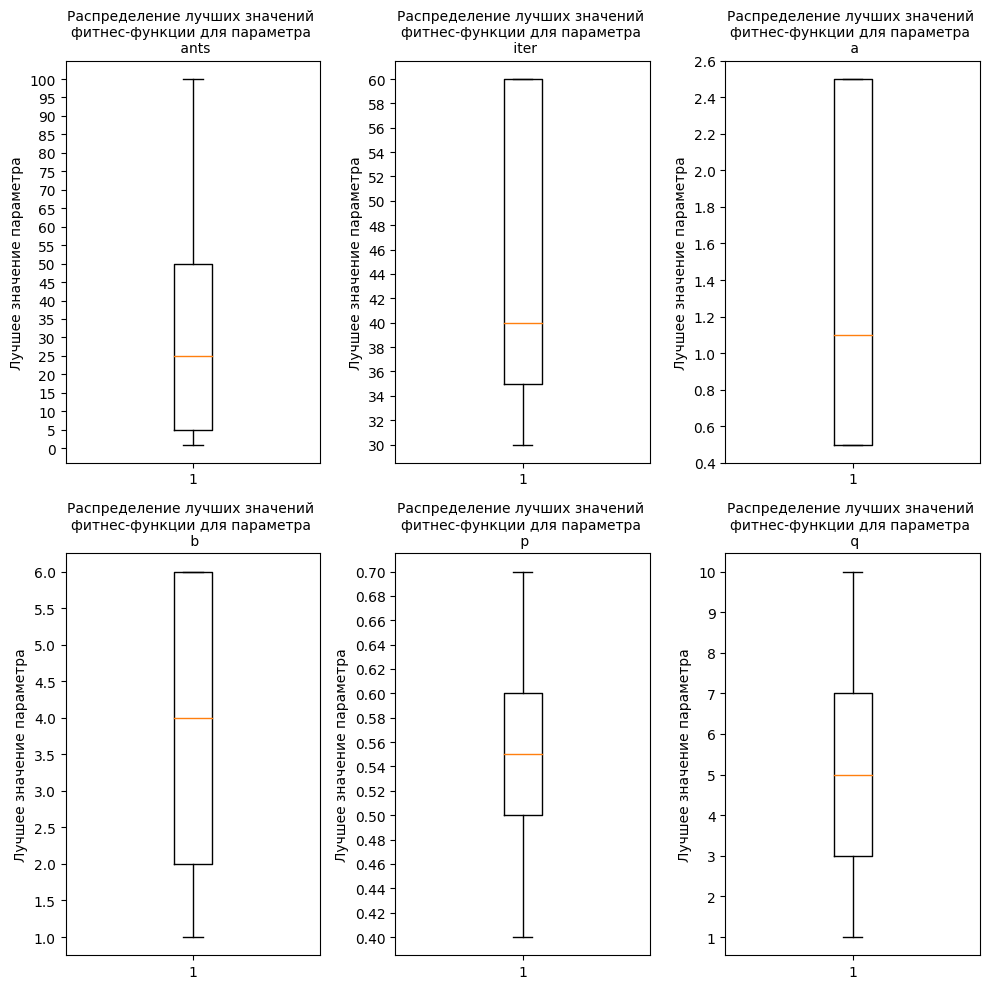

In [62]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

# Собираем лучшие значения фитнес-функции для каждого параметра
best_fitness_values = [result[0] for result in results if 100000<result[1].leng<145000] # Тут диапазон задать по графику выше

# Создаем график "ящик с усами" для каждого параметра
fig, axs = plt.subplots(2, 3, figsize=(10, 10))

titles = ["ants", "iter", "a", "b", "p", "q"]
locators = [5, 2, .2, .5, .02, 1]

for i in range(len(best_fitness_values[0])):
    row = i // len(axs[0])
    col = i % len(axs[0])
    axs[row, col].boxplot([bfv[i] for bfv in best_fitness_values])
    axs[row, col].set_title(f"Распределение лучших значений \nфитнес-функции для параметра \n {titles[i]}",fontdict={'fontsize':10})
    axs[row, col].yaxis.set_major_locator(ticker.MultipleLocator(locators[i]))
    axs[row, col].set_ylabel("Лучшее значение параметра")
plt.tight_layout()
plt.show()

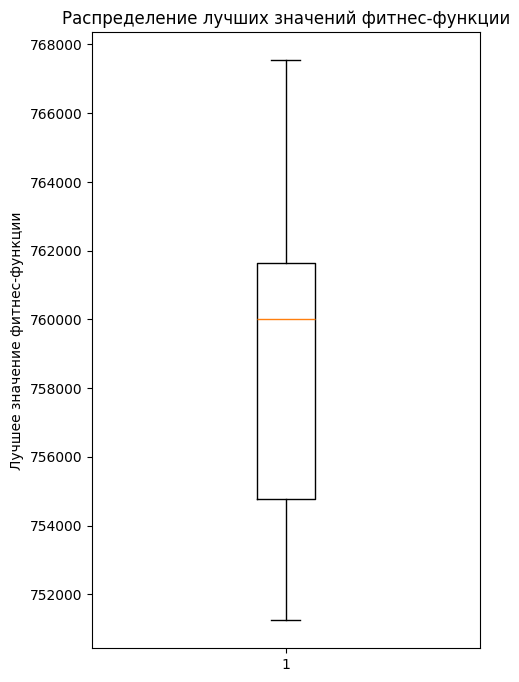

Лучший результат: 751248


In [28]:
import itertools
import sys
import random
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np

ants = [625 for i in range(0,10)]
iter = [40]
a = [1.1]
b = [4]
p = [0.55]
q = [5]

param_grid = list(itertools.product(ants, iter, a, b, p, q))

random.seed(10)

results = Parallel(n_jobs=-1)(delayed(run_algorithm)(params, matrix) for params in param_grid)  #n_jobs - кол-во ядер процессора

best_result = min(results, key=lambda x: x[1].leng)
best_path = best_result[1].leng
best_fitness_values = [result[1].leng for result in results]
fig = plt.figure(figsize=(5,8))
plt.boxplot(best_fitness_values)
plt.title("Распределение лучших значений фитнес-функции")
plt.ylabel("Лучшее значение фитнес-функции")
plt.show()
print(f"Лучший результат: {best_path}")

In [31]:
[x[1].leng for x in results]

[754526,
 759352,
 761057,
 767540,
 751248,
 761846,
 760645,
 755524,
 754276,
 766498]

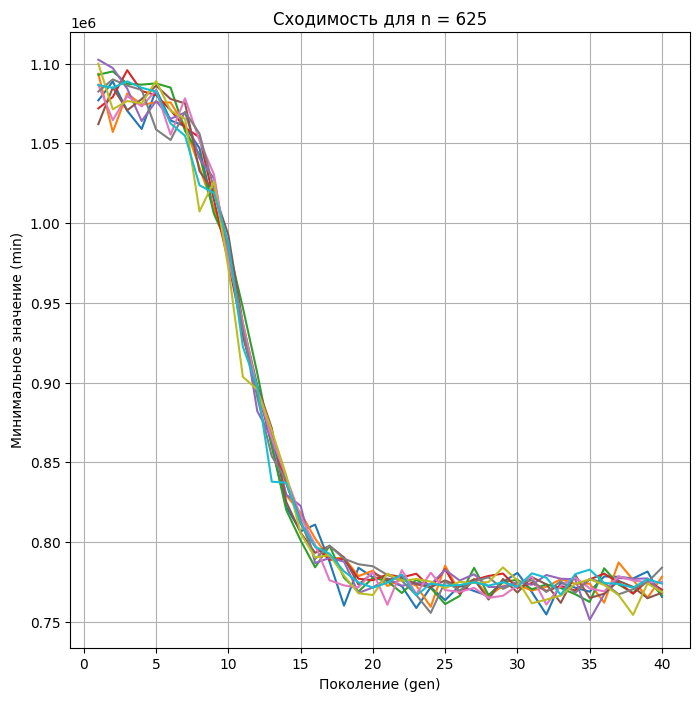

In [30]:
import matplotlib.pyplot as plt

mins_all = [x[2] for x in results]
gens_all = [[x for x in range(1,iter[0]+1)] for _ in range(10)]

plt.figure(figsize=(8, 8))
# Построй график
for mins, gens in zip(mins_all, gens_all):
    plt.plot(gens, mins)
# Настройка осей и заголовка
plt.xlabel('Поколение (gen)')
plt.ylabel('Минимальное значение (min)')
plt.title('Сходимость для n = 625')
# Отображение сетки
plt.grid(True)
# Отображение графика
plt.show()